In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black
%load_ext Cython

In [2]:
from math import exp

from nzthermo.const import E0, T0
import nzthermo

temperature = 273.15 + 20  # 20 degrees C
# P = E0 * exp(17.67 * (temperature - T0) / (temperature - 29.65)) # saturation vapor pressure
# P, 611.21 * exp(17.502 * (temperature - 273.15) *((temperature - 32.18)**(-1)))
E0, nzthermo.saturation_vapor_pressure(T0), 6.1121 * 1.004, 6.1115 * 1.004

(611.21, 611.21, 6.1365484, 6.135946000000001)

In [3]:
import gcsfs
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes


import nzthermo as nzt

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["xtick.bottom"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["xtick.labelbottom"] = False
plt.rcParams["ytick.labelleft"] = False

In [4]:
fs = gcsfs.GCSFileSystem(token="anon")
mapper = fs.get_mapper("gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr")
ds = xr.open_zarr(mapper)

longitude = ds["longitude"].to_numpy()
latitude = ds["latitude"].to_numpy()
extent = [longitude[0], longitude[-1], latitude[0], latitude[-1]]

ds

<xarray.Dataset> Size: 89TB
Dimensions:                                           (time: 93544,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_wind_speed                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    above_ground                                      (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, latitude, longitude) float32 388GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    vorticity                                         (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    wind_speed                                        (time, level, latitude, longitude) float32 5TB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>

In [5]:
pressure = ds.coords["level"].to_numpy().astype(np.float32) * 100.0  # (Pa) (13,)
temperature = ds["temperature"].isel(time=slice(0, 30)).to_numpy().astype(np.float32)  # (K) (30, 13, 721, 1440)
specific_humidity = (
    ds["specific_humidity"].isel(time=slice(0, 30)).to_numpy().astype(np.float32)
)  # (kg/kg) (30, 13, 721, 1440)

In [5]:
temperature[0, 0, ::12, 0]

array([197.48015, 196.40933, 196.28738, 195.59302, 195.519  , 195.73471,
       195.9201 , 197.89395, 200.65591, 203.50317, 205.06673, 207.30984,
       207.88297, 209.70383, 210.75208, 212.7365 , 213.22783, 214.64124,
       214.1802 , 214.57639, 211.96317, 210.80495, 209.44441, 209.36829,
       207.86041, 206.28839, 206.49564, 203.73157, 203.56802, 201.65482,
       203.65967, 205.21687, 207.54248, 210.90294, 209.29355, 205.13228,
       205.49956, 206.84741, 208.59708, 207.00883, 209.67   , 211.49086,
       213.09671, 216.7328 , 220.7277 , 222.52882, 225.16742, 225.56079,
       228.5434 , 229.89124, 231.1693 , 232.85129, 234.11455, 235.0782 ,
       235.94458, 237.05415, 237.18597, 237.56593, 238.87854, 238.90392,
       239.10553], dtype=float32)

In [6]:
# - weatherbench's levels are in reverse order
# - non vertical dimensions are flattened like (T, Z, Y, X) -> (T*Y*X, Z) || (N, Z)
P = pressure[::-1]
Z = len(P)
# This is a critical step in working with +4d data. Initially, the data is in the shape of
# (T, Z, Y, X) but we need to reshape it to (N, Z) where N == T*Y*X, but currently Z in the second
# dimension. So we need to move the Z dimension to the last dimension and so that we can squash the
# first three dimensions into one. This is done by using np.moveaxis and then reshaping the array
# to (N, Z) where N == T*Y*X
T = np.moveaxis(temperature[:, ::-1, :, :], 1, -1).reshape(-1, Z)  # (N, Z)
print(f"{temperature.shape} -> {T.shape} || (T, Z, Y, X) -> (N, Z)")
Td = nzt.dewpoint.from_specific_humidity(
    P[np.newaxis, :],
    np.moveaxis(specific_humidity[:, ::-1, :, :], 1, -1).reshape(-1, Z),
)  # (K) (N, Z)

(30, 13, 721, 1440) -> (31147200, 13) || (T, Z, Y, X) -> (N, Z)


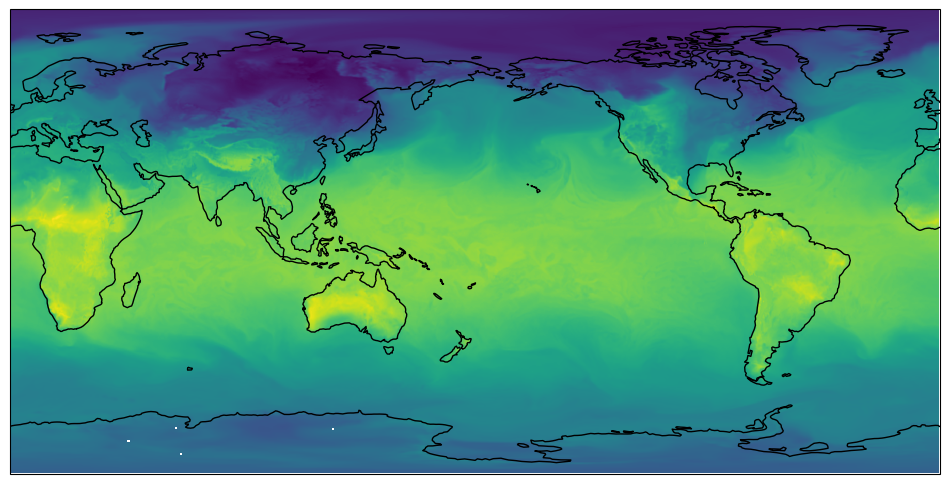

In [7]:
T0 = T[:, 0]
Td0 = Td[:, 0]

lr = nzt.moist_lapse(P, T0, Td0).reshape((temperature.shape[0],) + temperature.shape[2:] + (Z,))  # (T, Y, X, Z)

ax: GeoAxes = plt.axes(projection=ccrs.PlateCarree(180))
ax.coastlines()

ax.imshow(lr[0, ..., 0], origin="lower", extent=extent, transform=ccrs.PlateCarree());

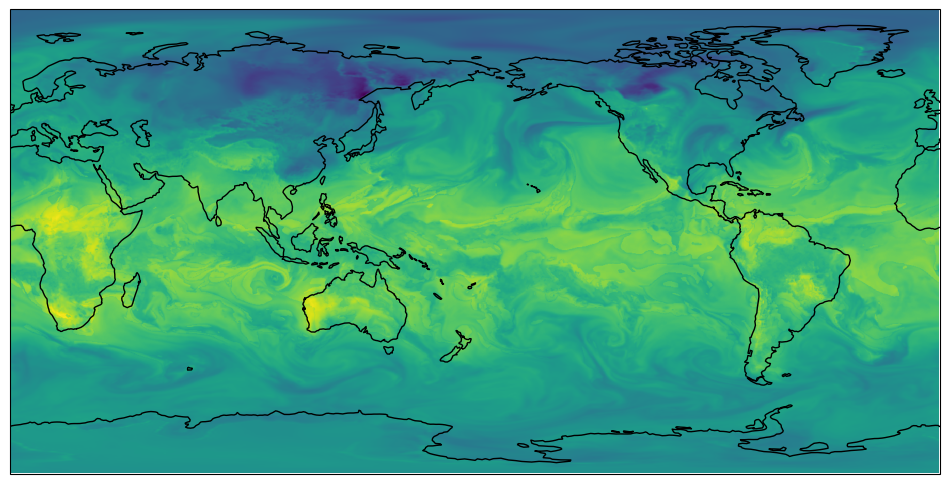

In [8]:
dcape = nzt.downdraft_cape(P, T, Td)  # (T*Y*X,) || (N,)
dcape = dcape.reshape((temperature.shape[0],) + temperature.shape[2:])  # (T, Y, X)

ax: GeoAxes = plt.axes(projection=ccrs.PlateCarree(180))
ax.coastlines()

ax.imshow(dcape[0, ...], origin="lower", extent=extent, transform=ccrs.PlateCarree());

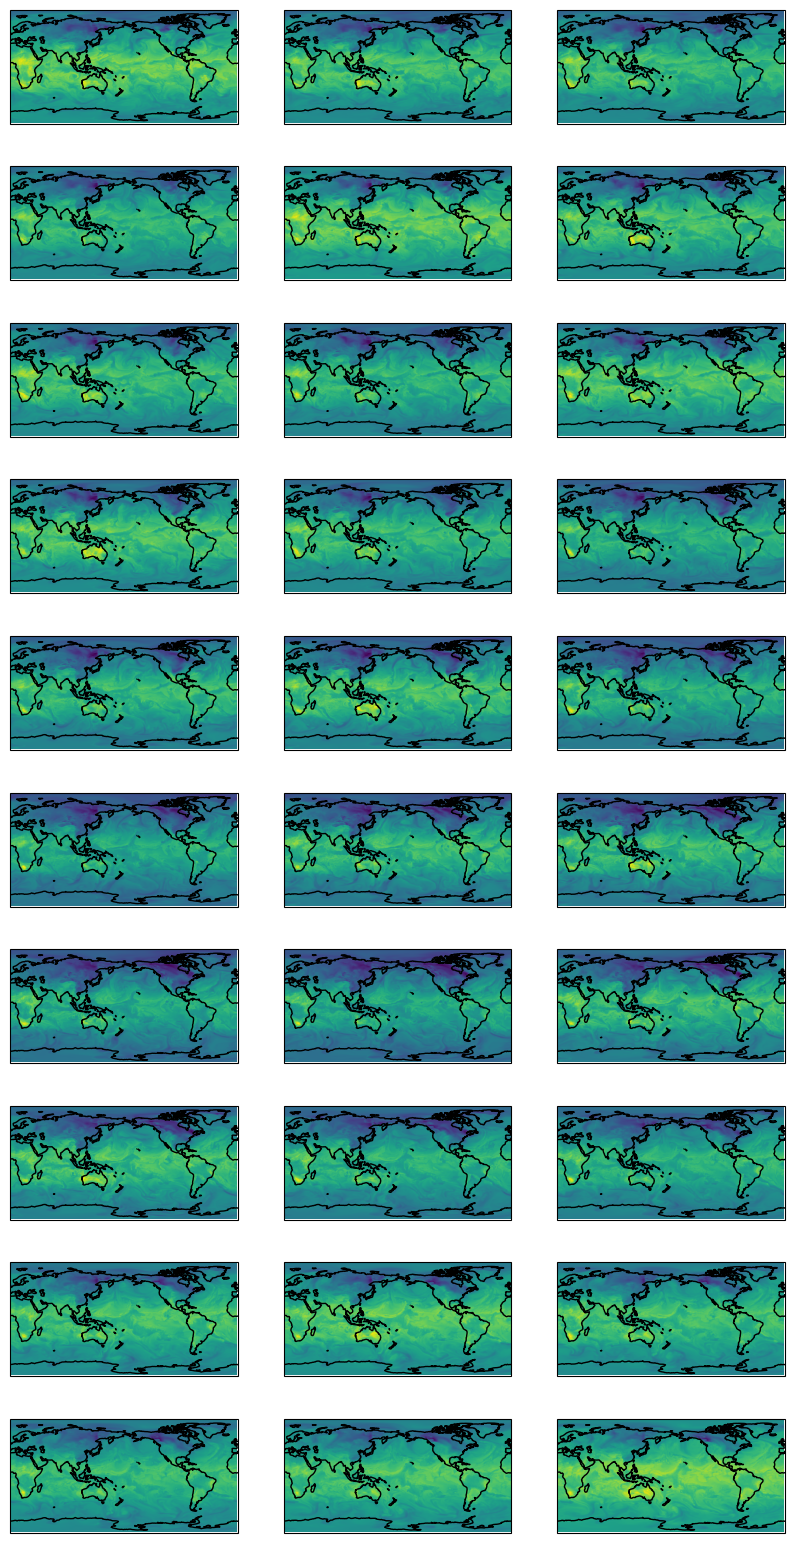

In [9]:
fig, axes = plt.subplots(dcape.shape[0] // 3, 3, figsize=(10, 20), subplot_kw={"projection": ccrs.PlateCarree(180)})
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.coastlines()
    ax.imshow(dcape[i], cmap="viridis", origin="lower", extent=extent, transform=ccrs.PlateCarree())

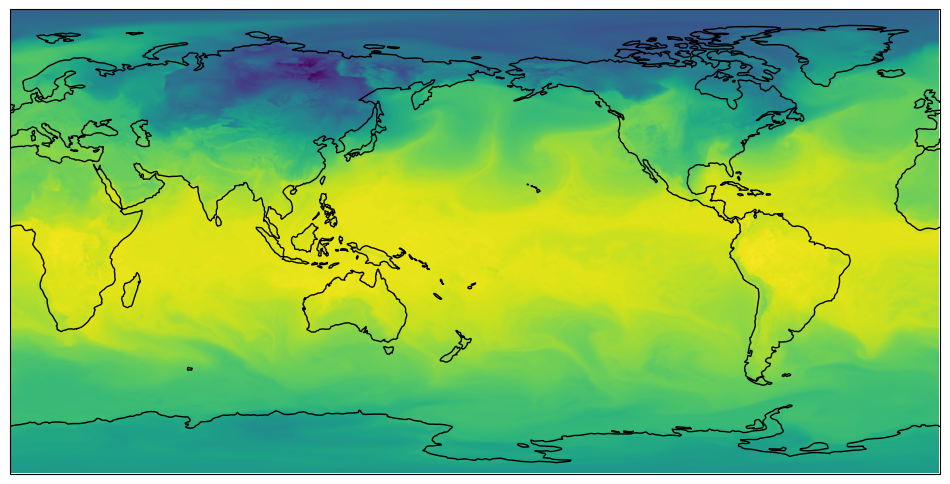

In [10]:
P0 = P[:1].repeat(T.shape[0])
T0 = T[:, 0]  # (T*Y*X)
Td0 = Td[:, 0]  # (T*Y*X)


wb = nzt.wet_bulb_temperature(P0, T0, Td0).reshape((temperature.shape[0],) + temperature.shape[2:])


# plt.imshow(wb[0, ...]);
ax: GeoAxes = plt.axes(projection=ccrs.PlateCarree(180))
ax.coastlines()

ax.imshow(wb[0, ...], origin="lower", extent=extent, transform=ccrs.PlateCarree());

# moist_lapse

In [11]:
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units

import nzthermo as nzt

N = 1000
Z = 20
P = np.linspace(101325, 10000, Z)[np.newaxis, :]
T = np.random.uniform(300, 200, N)

ml = nzt.moist_lapse(P, T)
assert ml.shape == (N, Z)
%timeit nzt.moist_lapse(P, T)

P = P[0] * units.Pa
T = T * units.kelvin
ml_ = [mpcalc.moist_lapse(P, T[i]).m for i in range(N)]  # type: ignore
%timeit [mpcalc.moist_lapse(P, T[i]).m for i in range(N)]

np.testing.assert_allclose(ml, ml_, rtol=1e-3)

1.22 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.53 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# lcl

In [16]:
P = np.random.uniform(101325, 10000, N)
T = np.random.uniform(300, 200, N)
Td = T - np.random.uniform(0, 10, N)

lcl_p, lcl_t = nzt.lcl(P, T, Td)
assert lcl_p.shape == (N,) == lcl_t.shape
%timeit nzt.lcl(P, T, Td)

P *= units.Pa
T *= units.kelvin
Td *= units.kelvin
lcl_p_, lcl_t_ = (x.m for x in mpcalc.lcl(P, T, Td))  # type: ignore
%timeit mpcalc.lcl(P, T, Td)

np.testing.assert_allclose(lcl_p, lcl_p_, rtol=1e-3)
np.testing.assert_allclose(lcl_t, lcl_t_, rtol=1e-3)

57.9 µs ± 8.34 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
240 µs ± 5.01 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# wet_bulb_temperature

In [36]:
P = np.random.uniform(101325, 10000, 1000).astype(np.float32)
T = np.random.uniform(300, 200, 1000).astype(np.float32)
Td = T - np.random.uniform(0, 10, 1000).astype(np.float32)

wb = nzt.wet_bulb_temperature(P, T, Td)
%timeit nzt.wet_bulb_temperature(P, T, Td)

P *= units.Pa
T *= units.kelvin
Td *= units.kelvin
wb_ = mpcalc.wet_bulb_temperature(P, T, Td).m
%timeit mpcalc.wet_bulb_temperature(P, T, Td)

np.testing.assert_allclose(wb, wb_, rtol=1e-3)

1.17 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
390 ms ± 2.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# downdraft_cape

In [35]:
pressure = np.array(
    [1013, 1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 650, 600, 550, 500, 450, 400, 350, 300],
).astype(np.float32)
pressure *= 100.0
temperature = np.array(
    [
        [243, 242, 241, 240, 239, 237, 236, 235, 233, 232, 231, 229, 228, 226, 235, 236, 234, 231, 226, 221, 217, 211],
        [250, 249, 248, 247, 246, 244, 243, 242, 240, 239, 238, 236, 235, 233, 240, 239, 236, 232, 227, 223, 217, 211],
        [293, 292, 290, 288, 287, 285, 284, 282, 281, 279, 279, 280, 279, 278, 275, 270, 268, 264, 260, 254, 246, 237],
        [300, 299, 297, 295, 293, 291, 292, 291, 291, 289, 288, 286, 285, 285, 281, 278, 273, 268, 264, 258, 251, 242],
    ],
    dtype=np.float32,
)
dewpoint = np.array(
    [
        [224, 224, 224, 224, 224, 223, 223, 223, 223, 222, 222, 222, 221, 221, 233, 233, 231, 228, 223, 218, 213, 207],
        [233, 233, 232, 232, 232, 232, 231, 231, 231, 231, 230, 230, 230, 229, 237, 236, 233, 229, 223, 219, 213, 207],
        [288, 288, 287, 286, 281, 280, 279, 277, 276, 275, 270, 258, 244, 247, 243, 254, 262, 248, 229, 232, 229, 224],
        [294, 294, 293, 292, 291, 289, 285, 282, 280, 280, 281, 281, 278, 274, 273, 269, 259, 246, 240, 241, 226, 219],
    ],
    dtype=np.float32,
)


dcape = nzt.downdraft_cape(pressure, temperature, dewpoint)

%timeit nzt.downdraft_cape(pressure, temperature, dewpoint)

P = pressure * units.Pa
T = temperature * units.kelvin
Td = dewpoint * units.kelvin
dcape_ = [mpcalc.downdraft_cape(P, T[i], Td[i])[0].m for i in range(temperature.shape[0])]  # type: ignore
%timeit [mpcalc.downdraft_cape(P, T[i], Td[i]) for i in range(temperature.shape[0])]

np.testing.assert_allclose(dcape, dcape_, rtol=1e-2)

2.41 ms ± 877 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.5 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
